# 1. Creating ENV for ChromeDino

[Chrome_Dino Game](chrome://dino)

[Tesseract installer for Windows](https://digi.bib.uni-mannheim.de/tesseract/tesseract-ocr-w64-setup-5.3.3.20231005.exe)

In [15]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

^C


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
# Import necessary libraries
from mss import mss  # Screen capturing library
import pydirectinput  # Library for programmatically controlling the mouse and keyboard
import cv2  # OpenCV library for computer vision tasks
import numpy as np  # NumPy for numerical operations
import pytesseract  # Tesseract OCR library for text recognition
from matplotlib import pyplot as plt  # Matplotlib for plotting
import time  # Time module for adding delays
from gym import Env  # Gym library for defining RL environments
from gym.spaces import Box, Discrete  # Gym spaces for defining observation and action spaces

# Set the Tesseract OCR executable path
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [ ]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 320, 'left': 0, 'width': 1200, 'height': 430}
        self.done_location = {'top': 405, 'left': 630, 'width': 330, 'height': 70}
        
        
    def step(self, action):
        action_map = {
            0:'space',
            1: 'down', 
            2: 'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])

        done, done_cap = self.get_done() 
        observation = self.get_observation()
        reward = 1 
        info = {}
        return observation, reward, done, info
        
    
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
        
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

In [ ]:
env = WebGame()

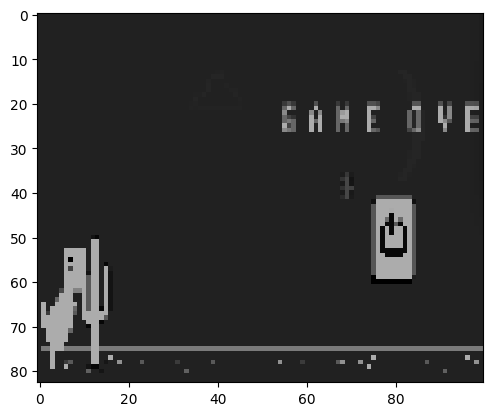

In [ ]:
obs=env.get_observation()
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

'GAME'

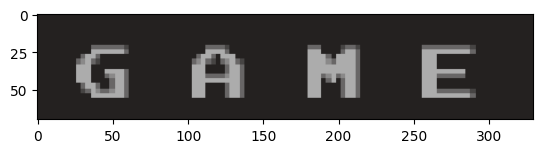

In [ ]:
done, done_cap = env.get_done()
plt.imshow(done_cap)
pytesseract.image_to_string(done_cap)[:4]

In [ ]:
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode+1, total_reward)) 

Total Reward for episode 1 is 11
Total Reward for episode 2 is 37


KeyboardInterrupt: 

In [ ]:
# Check Environment    
from stable_baselines3.common import env_checker
env_checker.check_env(env)

In [ ]:
env.close()

# 2. Setting up Callbacks

In [ ]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [ ]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [ ]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

# 3. Training the Model

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [ ]:
env = WebGame()

In [ ]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000)

In [ ]:
model.learn(total_timesteps=100000, callback=callback)

In [ ]:
model.load('')

In [ ]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

In [ ]:
env.close()